In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

Uniform full monte

In [21]:
duwamish_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Duwamish/duwamish_fullmonte_depths.pq")
kanawha_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/kanawha_fullmonte_depths.pq")
trinity_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/trinity_fullmonte_depths.pq")
denton_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/denton_fullmonte_depths.pq")

datasets = {
    "Duwamish": duwamish_fullmonte_depths,
    "Kanawha": kanawha_fullmonte_depths,
    "Trinity": trinity_fullmonte_depths,
    "Denton": denton_fullmonte_depths,
}

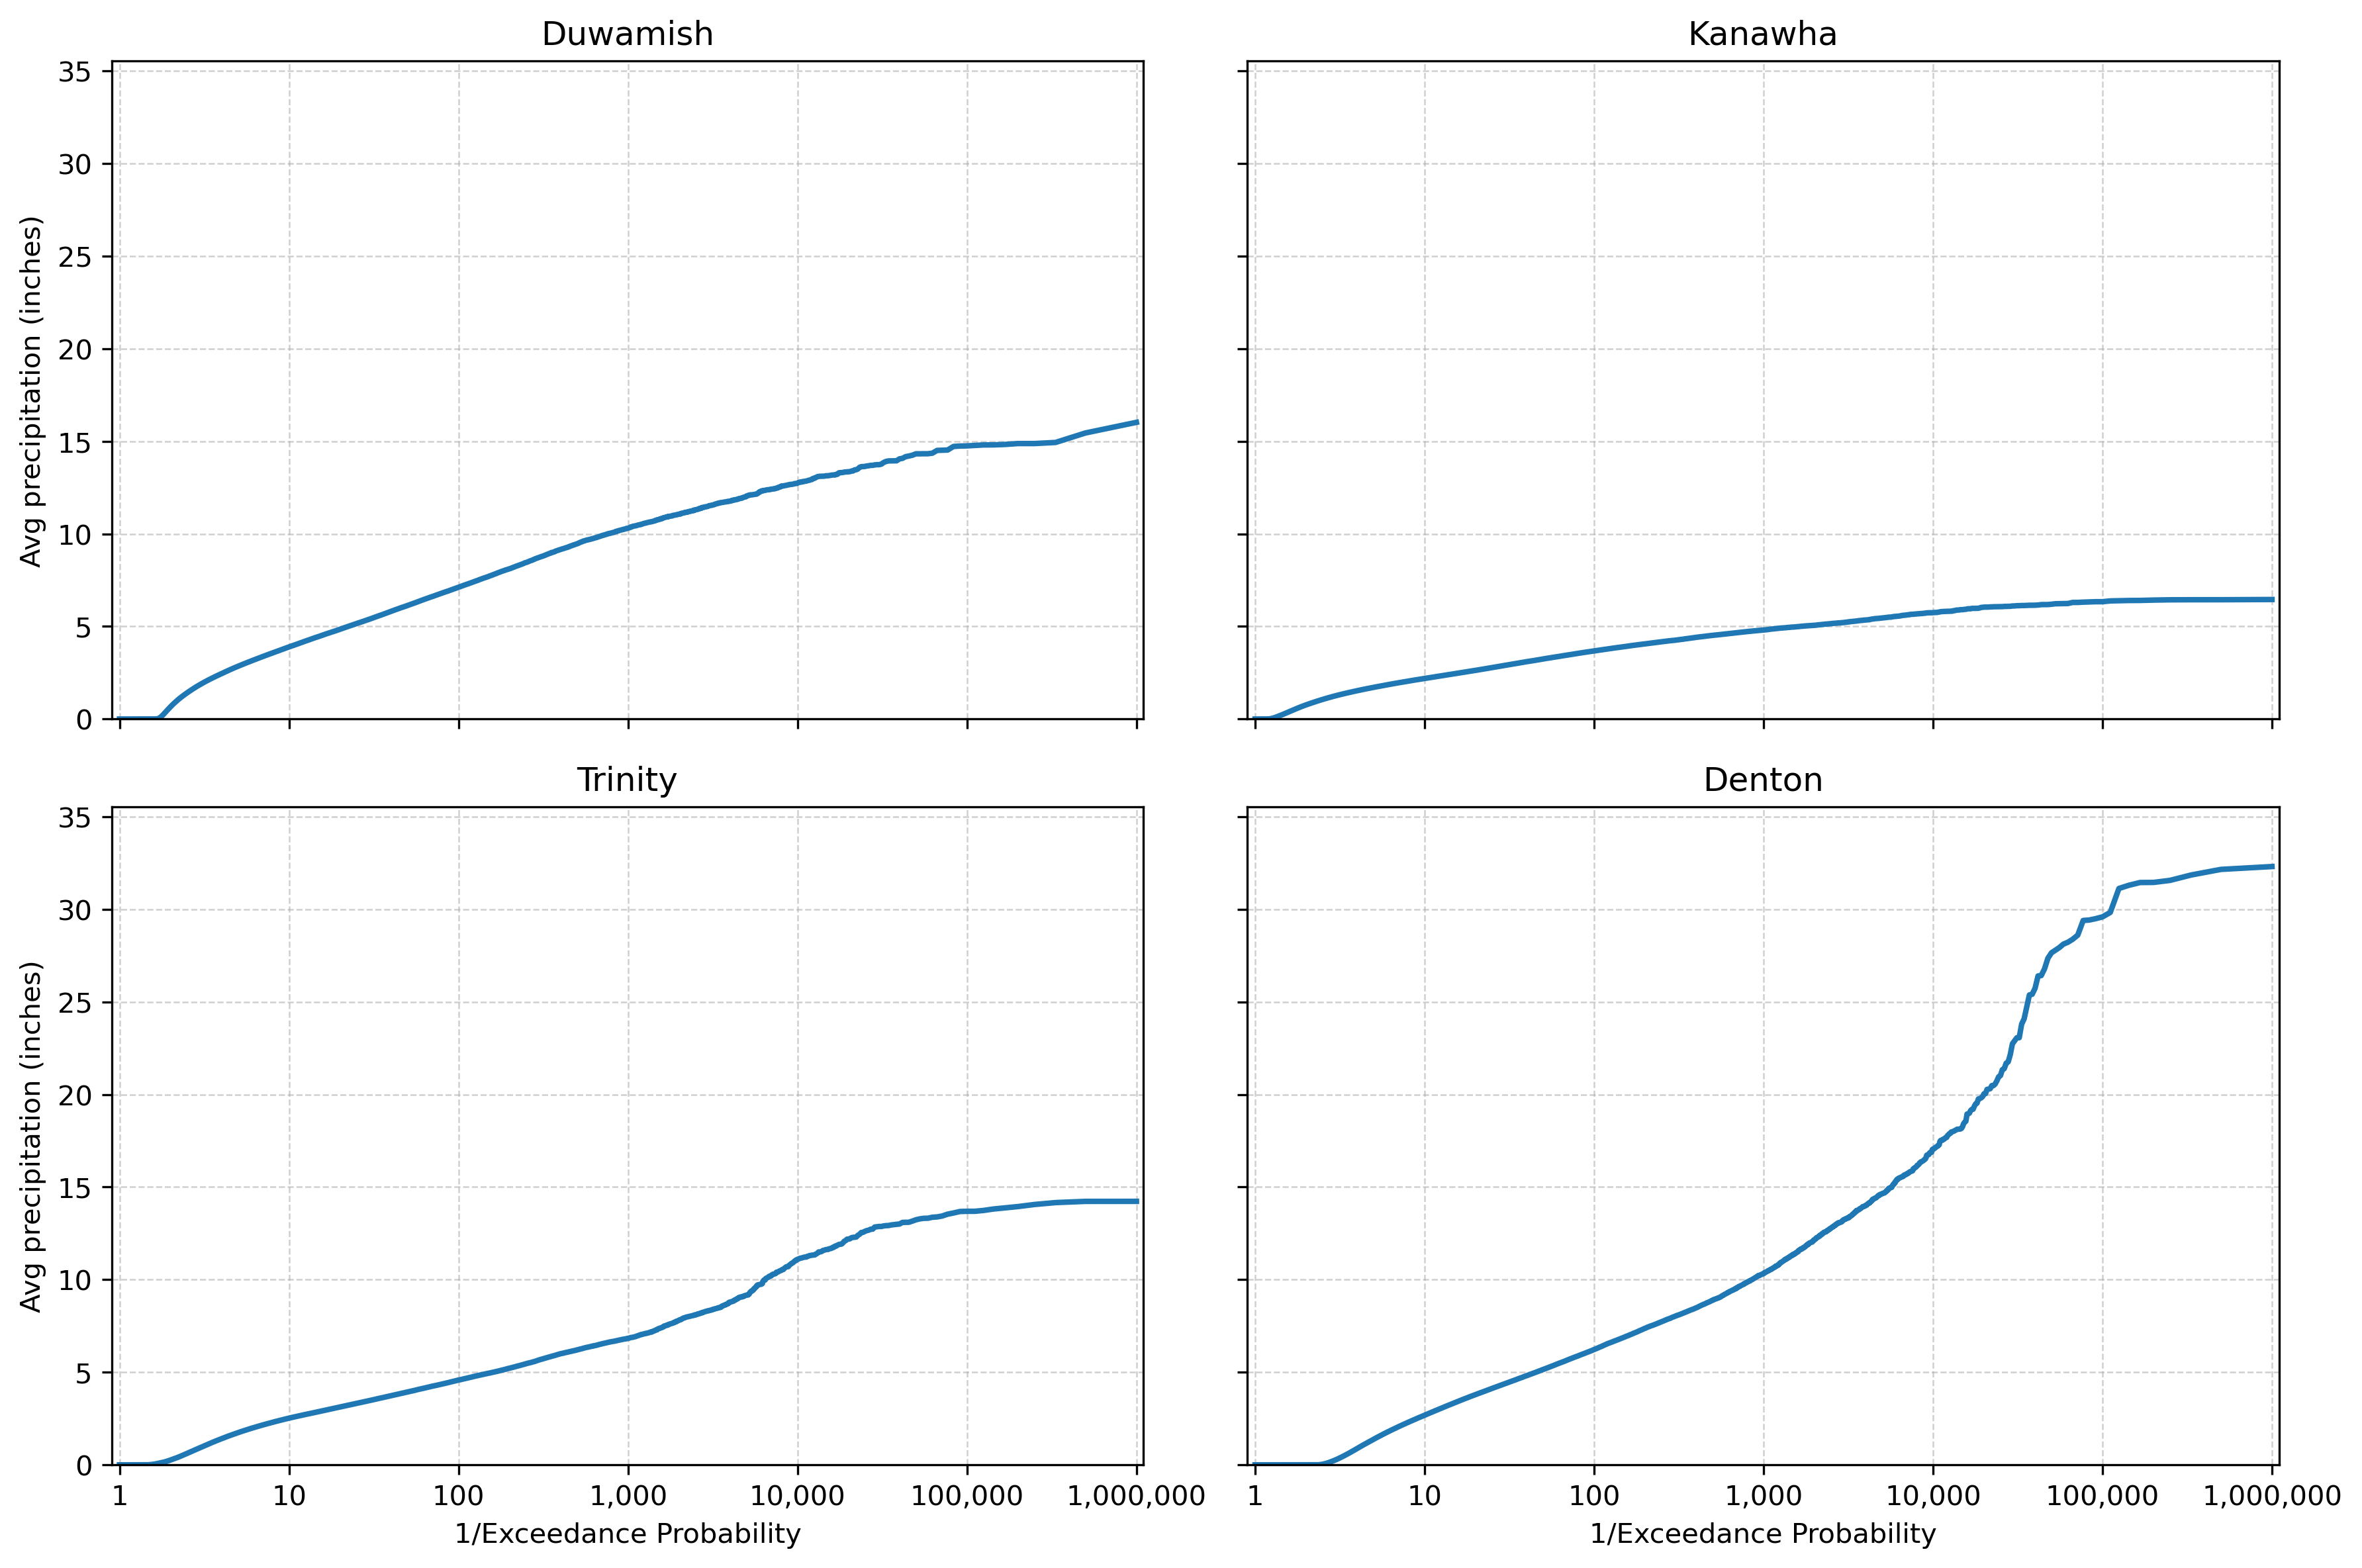

In [22]:
for df in datasets.values():
    df["precip_in"] = df["precip_avg_mm"] / 25.4
    df["return_period"] = 1.0 / df["exc_prb"]
    df.sort_values("return_period", inplace=True)

all_rp = np.concatenate([df["return_period"].values for df in datasets.values()])
all_precip_in = np.concatenate([df["precip_in"].values for df in datasets.values()])

x_min, x_max = all_rp.min(), all_rp.max()
y_min, y_max = all_precip_in.min(), all_precip_in.max()
x_min, x_max = max(1e-2, x_min * 0.9), x_max * 1.1
y_min, y_max = y_min * 0.9, y_max * 1.1

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, sharex=True, sharey=True)
axes = axes.ravel()

for i, (ax, (name, df)) in enumerate(zip(axes, datasets.items())):
    ax.plot(df["return_period"], df["precip_in"], lw=2.0)  # thicker line
    ax.set_title(name)
    ax.set_xscale("log")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0, subs=[1.0]))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.xaxis.set_minor_locator(mticker.NullLocator())  # no minor ticks

    ax.grid(True, which="both", ls="--", lw=0.6, alpha=0.6)

    if i // 2 == 1:
        ax.set_xlabel("1/Exceedance Probability")
    else:
        ax.set_xlabel("")
        ax.tick_params(labelbottom=False)

    if i % 2 == 0:
        ax.set_ylabel("Avg precipitation (inches)")
    else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)

fig.tight_layout()
plt.show()
